  Мы владеем сетью магазинов, в которых продаются различные товары. Наши сотрудники
  собрали датасет из 8523 продаж товаров в различных магазинах нашей сети. Наша задача
  построить модель, предсказывающую продажи каждого продукта в конкретном магазине.
  Используя эту модель, попробовать выявить факторы, больше всего влияющие на увеличение
  продаж. Описание датасета:

 | Variable | Description |
 | -------- |-------------|
 | Item_Identifier | Id продукта |
 | Item_Weight | Вес продукта |
 | Item_Fat_Content | Содержание жира в продукте|
 | Item_Visibility | %полок, отведенный под наш продукт в конкретном магазине |
 | Item_Type | Категория продукта |
 | Item_MRP | Максимальная цена продажи продукта |
 | Outlet_Identifier | Идентификатор магазина |
 | Outlet_Establishment_Year | Год открытия магазина |
 | Outlet_Size | Площадь магазина |
 | Outlet_Location_Type | Тип города, в котором расположен магазин |
 | Outlet_Type | Признак является ли магазин продуктовым или супермаркетом |
 | Item_Outlet_Sales | Продажи продукта в конкретном магазине. Именно ее и надо предсказывать |

  В результате работы должен получиться:
  + Jupyter-ноутбук с моделью
  + Признаки, влияющие больше всего на уровень продаж
  + Датасет, если после ваших манипуляций он отличается от исходного;
  + Документ с обоснованием решения и краткими результатами: какие техники и почему
    использовали, что получили, что можно улучшить (можно в рамках jupyter notebook’а)

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data = pd.read_csv("./data.csv")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  7060 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  6113 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.1+ KB


В данных есть пустые значения Item_Weight и Outlet_Size. Второе поле нечислового типа. Посмотрим на нечисловые поля (на их значения)

In [5]:
df_objects = data[data.select_dtypes(np.object).columns]
pd.DataFrame(
    [(c, len(df_objects[c].unique())) for c in df_objects.columns],
    columns=["Column name", "Unique values count"])

,Column name,Unique values count
0,Item_Identifier,1559
1,Item_Fat_Content,5
2,Item_Type,16
3,Outlet_Identifier,10
4,Outlet_Size,4
5,Outlet_Location_Type,3
6,Outlet_Type,4


 Идентификатор продукта(Item_Identifier) и идентификатор магазина(Outlet_Identifier) прокидывать смысла нет, т.к. они не несут для модели какую-то ценность.

In [6]:
df_target_column = 'Item_Outlet_Sales'
df_identifier_columns = ['Item_Identifier', 'Outlet_Identifier']
df_numeric_columns = ['Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']
df_numeric_columns_with_null = ['Item_Weight']
df_enum_columns = ['Item_Fat_Content', 'Item_Type', 'Outlet_Location_Type', 'Outlet_Type']
df_enum_columns_with_null = ['Outlet_Size']

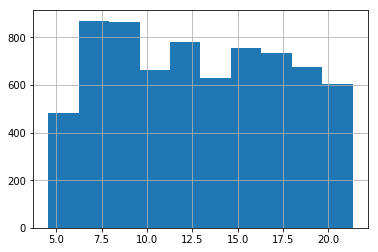

In [7]:
data.Item_Weight.hist()

In [8]:
data.Outlet_Size.value_counts(dropna=False)

Medium    2793
NaN       2410
Small     2388
High       932
Name: Outlet_Size, dtype: int64

В качестве заполнителя пустых ячеек для Item_Weight выберем среднее, а для Outlet_Size введем отдельное значение Unknown

In [9]:
converter = make_pipeline(
    make_column_transformer(
        ('passthrough', df_numeric_columns),
        (SimpleImputer(strategy='mean'), df_numeric_columns_with_null),
        (OneHotEncoder(sparse=False), df_enum_columns),
        (make_pipeline(
            SimpleImputer(strategy='constant', fill_value='Unknown'),
            OneHotEncoder(sparse=False)
            ), df_enum_columns_with_null)
    ),
    StandardScaler()
)

In [10]:
converted_data = converter.fit_transform(data)

In [11]:
converted_data.shape

(8523, 36)

Также потребуются имена полученных столбцов для дальнейшего анализа

In [12]:
inner_column_transformer = converter.named_steps['columntransformer']
converted_data_columns = df_numeric_columns + df_numeric_columns_with_null
converted_data_columns.extend(inner_column_transformer.named_transformers_['onehotencoder'].get_feature_names(df_enum_columns))
converted_data_columns.extend(inner_column_transformer.named_transformers_['pipeline'].named_steps['onehotencoder'].get_feature_names(df_enum_columns_with_null))
print(converted_data_columns)

['Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year', 'Item_Weight', 'Item_Fat_Content_LF', 'Item_Fat_Content_Low Fat', 'Item_Fat_Content_Regular', 'Item_Fat_Content_low fat', 'Item_Fat_Content_reg', 'Item_Type_Baking Goods', 'Item_Type_Breads', 'Item_Type_Breakfast', 'Item_Type_Canned', 'Item_Type_Dairy', 'Item_Type_Frozen Foods', 'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks', 'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat', 'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack Foods', 'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods', 'Outlet_Location_Type_Tier 1', 'Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 3', 'Outlet_Type_Grocery Store', 'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2', 'Outlet_Type_Supermarket Type3', 'Outlet_Size_High', 'Outlet_Size_Medium', 'Outlet_Size_Small', 'Outlet_Size_Unknown']


Делим данные на тренировочные и тестовые в соотношении 80/20

In [13]:
X_train, X_val, y_train, y_val = train_test_split(converted_data, data[df_target_column], test_size=0.2)

Далее нужно построить регрессионную модель. Модель должна кроме предсказания давать информацию о степени влияния параметра на результат. Модели на основе деревьев подходят по описанным критериям. В качестве метрики логично использовать mse. Также будем подбирать гиперпараметры решетчатым поиском.

In [14]:
models = [
    (DecisionTreeRegressor(), [dict(), dict(
        criterion=['mse', 'friedman_mse'],
        splitter = ['best', 'random'],
        max_depth = [None, 100, 500, 1000],
        min_samples_split = [2, 4, 8],
        min_samples_leaf = [1, 2, 3]
    )]),
    (AdaBoostRegressor(), [dict(), dict(
        n_estimators=[50, 100, 200, 500],
        learning_rate=[1.0, 5.0, 10.],
        loss=['linear', 'square', 'exponential']
    )]),
    (ExtraTreesRegressor(), [dict(), dict(
        n_estimators=[50, 100, 200, 500],
        max_depth = [None, 10, 20, 50],
        min_samples_split = [2, 4, 8],
        min_samples_leaf = [1, 2, 3]
    )]),
    (GradientBoostingRegressor(), [dict(), dict(
        n_estimators=[10, 100, 500],
        loss=['ls', 'lad', 'huber', 'quantile'],
        learning_rate=[0.1, 0.2, 1.],
        criterion=['mse', 'friedman_mse'],
    )]),
    (RandomForestRegressor(), [dict(), dict(
        n_estimators=[10, 100, 500],
        max_depth = [None, 10, 20, 50],
        min_samples_split = [2, 4, 8],
        min_samples_leaf = [1, 2, 3]
    )]),
]

In [15]:
results = []
for estimator, params in models:
    start = datetime.now()
    gs = GridSearchCV(estimator, params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
    gs.fit(X_train, y_train)
    end = datetime.now()
    y_pred = gs.predict(X_val)
    r2, mse = r2_score(y_val, y_pred), mean_squared_error(y_val, y_pred)
    results.append((gs.best_estimator_, gs.best_params_, r2, mse, end - start))

C:\Users\Gordeychik\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [16]:
df_results = [(r[0].__class__.__name__, r[1], r[2], r[3], r[4]) for r in results]
pd.DataFrame(df_results, columns=['estimator', 'best params', 'r2', 'mse', 'time']).sort_values(by=['mse'], ascending=True)

,estimator,best params,r2,mse,time
3,GradientBoostingRegressor,"{'criterion': 'mse', 'learning_rate': 0.1, 'lo...",0.582088,1.191422e+06,00:01:35.568409
4,RandomForestRegressor,"{'max_depth': 10, 'min_samples_leaf': 3, 'min_...",0.567638,1.232617e+06,00:06:42.520634
2,ExtraTreesRegressor,"{'max_depth': 10, 'min_samples_leaf': 3, 'min_...",0.566139,1.236892e+06,00:08:30.251478
0,DecisionTreeRegressor,"{'criterion': 'mse', 'max_depth': None, 'min_s...",0.391432,1.734962e+06,00:00:12.131319
1,AdaBoostRegressor,{},0.376827,1.776600e+06,00:00:29.870987


In [17]:
best_model_tuple = min(results, key=lambda x: x[3])
best_model = best_model_tuple[0]

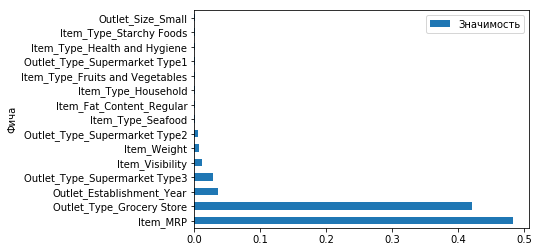

In [18]:
feature_importances_list = list(zip(converted_data_columns, best_model.feature_importances_))
feature_importances_list.sort(key=lambda x: x[1], reverse=True)

feature_importance_columns=['Фича', 'Значимость']
pd.DataFrame(feature_importances_list, columns=feature_importance_columns).head(15).plot.barh(*feature_importance_columns)
plt.show()

In [19]:
data.Outlet_Type.value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

Как показывает самая удачная получившаяся модель что самыми значимыми параметрами влияющие на продажи являются максимальная цена продажи продукта (Item_MRP) и тип магазина (Outlet_Type), а именно магазины типа Grocery Store. Остальные признаки имеют очень маленький вклад.